# 필요한 라이브러리 갖고 오기

In [7]:
import torch
import torch.nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import torch.optim
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# MNIST 데이터셋 불러오기와 MINI_Batch를 위한 DataLoader 생성 (데이터 파이프라인)

In [8]:
# MNIST 데이터셋 불러오기
train_data=datasets.MNIST('DeepLearningVision\data',True,transforms.ToTensor(),
                       None,True)

test_data=datasets.MNIST('DeepLearningVision\data',False,transforms.ToTensor(),
                       None,True)

# 데이터셋의 클래스 객체 저장
classes=train_data.classes

# train_data 데이터셋 정보를 확인 (dir(train_data))
print(f'train_data의 개수: {len(train_data)}')
print(f'test_data의 개수: {len(test_data)}')
print(f'train_data[0]: {train_data[0]}') # 튜플 (배열,클래스넘버)
print(f'train_data[0].shape:{train_data[0][0].shape}') # 배열의 shape
print(f'train_data[0][0]의 자료형: {type(train_data[0][0])}') # torch.Tensor형

# 데이터셋을 BATCH_SIZE (SGD:Stochastic Gradient Descent) 스토캐스택 경사하강법을 하기 위한 DataLoader 생성
train_dataloader=DataLoader(dataset=train_data,
                            batch_size=32,
                            shuffle=True)

test_dataloader=DataLoader(dataset=test_data,
                           shuffle=False,
                           batch_size=32)
print(f'torch_version:{torch.__version__}')
# dataloader의 기능 function 확인 (class method, attribution)
print(dir(train_dataloader))
print(f'train_dataloader: {next(iter(train_dataloader))[0].shape}')
print(f'train_dataloader의 개수: {len(train_dataloader)}') # 60000 // 32

train_data의 개수: 60000
test_data의 개수: 10000
train_data[0]: (tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

# 모델 생성 및 Optimizer와 Loss Function 생성

In [9]:
# Train_dataloader를 학습하기 위한 딥러닝 신경망 모델 생성
# Fully Connected Layer 2개 생성
class MNISTModel(torch.nn.Module):
    def __init__(self,
                 input_shape:int,
                 hidden_units:int,
                 output_shape:int):
        super().__init__()
        self.layer1=torch.nn.Sequential(
                            torch.nn.Flatten(),
                            torch.nn.Linear(in_features=input_shape,
                                                   out_features=hidden_units),
                            torch.nn.Linear(in_features=hidden_units,
                                                   out_features=output_shape)
        )
    def forward(self,x):
        return self.layer1(x)

# 28 * 28 사이즈의 이미지 크기이기에 픽셀 하나를 노드 하나로 취급 
# hidden unit 512개의 노드
# output_shape은 클래스가 10개 있으므로, 출력층 노드도 10개로 지정
model_0=MNISTModel(input_shape=28*28,
                   hidden_units=512,
                   output_shape=10)

# 최적화 기법 (SGD) 정의
# 최적화할 손실함수 정의 MSELoss : Mean Squared Loss (평균 제곱 오차)
optimizer=torch.optim.SGD(params=model_0.parameters(),lr=0.1) # model_0의 파라미터를 갱신, learning rate는 0.01 (가중치 - 0.01 * Loss에 대한 해당 가중치의 Gradient)
loss_fn=torch.nn.CrossEntropyLoss()

# 모델 학습하는데 걸리는 시간 측정을 위한 함수
from timeit import default_timer as timer
def print_train_time(start:float,
                     end: float,
                     device:torch.device="cuda"):
  """Prints difference between start and end time."""
  total_time=end-start
  print(f"{device}상에서 걸린 학습시간: {total_time:.3f} seconds")
  return total_time


# 학습과 검증 Engine 구현 

In [10]:
# acc 평가
def accuracy_fn(prediction,true):
    correct=torch.eq(prediction,true).sum().item()
    acc=(correct/len(true))*100
    return acc

start_time=timer()
train_acc_list=[]
train_loss_list=[]
test_loss_list=[]
test_acc_list=[]
EPOCH=5 # 60000개의 데이터에 대한 훑고감 정도? 10번 시행
for epoch in tqdm(range(EPOCH)):
    train_loss=0
    train_acc=0
    for Batch,(x_train,y_train) in enumerate(train_dataloader):
        model_0.train(True)
        # Do forward pass (로짓 계산)
        y_logits=model_0(x_train)
        # Calculate loss (손실 계산)
        loss=loss_fn(y_logits,y_train)
        train_loss+=loss
        # acc 계산
        train_acc+=accuracy_fn(y_logits.argmax(dim=1),y_train)
        # optimizer zero grad (경사 추적 x)
        optimizer.zero_grad()
        # loss backward (역전파를 통한 gradient 구하기)
        loss.backward()
        # optimizer step (가중치 갱신)
        optimizer.step()
    train_loss/=len(train_dataloader)
    train_acc/=len(train_dataloader)
    train_loss_list.append(train_loss.detach().numpy())
    train_acc_list.append(train_acc)
    print(f' train_loss: {train_loss}')
    # Evaluation
    test_loss=0.0
    test_acc=0.0
    model_0.eval()
    with torch.inference_mode():
        for X_test,y_test in test_dataloader:
            # Forward Pass
            test_logits=model_0(X_test)
            # 손실 계산
            test_loss+=loss_fn(test_logits,y_test)
        test_acc+=accuracy_fn(test_logits.argmax(dim=1),y_test)
        test_loss /= len(train_dataloader)
        test_acc_list.append(test_acc)
        test_loss_list.append(test_loss)
    print(f"Train_Loss: {train_loss:.2f}, Train_acc: {train_acc:.2f}, Test_Loss: {test_loss:.2f}, Test_Acc: {test_acc:.2f}")
end_time=timer()
print_train_time(start_time,end_time)

  0%|          | 0/5 [00:00<?, ?it/s]

 train_loss: 0.3830031752586365


 20%|██        | 1/5 [00:16<01:06, 16.69s/it]

Train_Loss: 0.38, Train_acc: 89.21, Test_Loss: 0.05, Test_Acc: 93.75
 train_loss: 0.30837327241897583


 40%|████      | 2/5 [00:33<00:50, 16.74s/it]

Train_Loss: 0.31, Train_acc: 91.23, Test_Loss: 0.05, Test_Acc: 93.75
 train_loss: 0.2957610785961151


 60%|██████    | 3/5 [00:48<00:31, 15.73s/it]

Train_Loss: 0.30, Train_acc: 91.69, Test_Loss: 0.05, Test_Acc: 93.75
 train_loss: 0.29009661078453064


 80%|████████  | 4/5 [01:02<00:15, 15.29s/it]

Train_Loss: 0.29, Train_acc: 91.81, Test_Loss: 0.05, Test_Acc: 93.75
 train_loss: 0.2850431203842163


100%|██████████| 5/5 [01:16<00:00, 15.36s/it]

Train_Loss: 0.29, Train_acc: 91.98, Test_Loss: 0.05, Test_Acc: 100.00
cuda상에서 걸린 학습시간: 76.801 seconds


76.80124589999997

# 성능 탐구

<Figure size 1200x800 with 0 Axes>

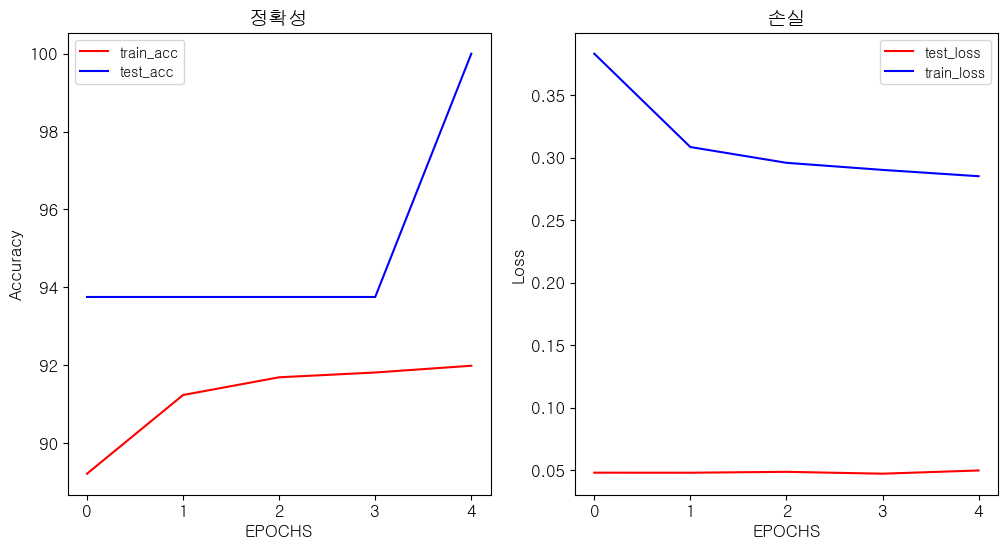

In [25]:
# 결과 플로팅 하고싶다.
plt.figure(figsize=(12,8))

from matplotlib import font_manager, rc
font_path = "c:\WINDOWS\Fonts\GULIM.TTC"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

plt.figure(figsize=(12,6))
plt.rc('font', size=12) 
plt.subplot(1,2,1)
plt.plot(np.arange(EPOCH),train_acc_list,label='train_acc',color='red')
plt.plot(np.arange(EPOCH),test_acc_list,label='test_acc',color='blue')
plt.xlabel('EPOCHS')
plt.title('정확성')
plt.ylabel("Accuracy")
plt.legend(fontsize=10)

plt.subplot(1,2,2)
plt.plot(np.arange(EPOCH),test_loss_list,label='test_loss',color='red')
plt.plot(np.arange(EPOCH),train_loss_list,label='train_loss',color='blue')
plt.xlabel('EPOCHS')
plt.title('손실')
plt.ylabel("Loss")
plt.legend(fontsize=10)
plt.show()

# Model 파라미터 Save

In [40]:
print(f'모델 파라미터 형태 파악: \n {model_0.state_dict()} \n')

모델 파라미터 형태 파악: 
 OrderedDict([('layer1.1.weight', tensor([[ 0.0024,  0.0234, -0.0012,  ..., -0.0274, -0.0236,  0.0332],
        [-0.0135,  0.0156,  0.0342,  ..., -0.0157, -0.0237,  0.0265],
        [-0.0122,  0.0258, -0.0029,  ...,  0.0300,  0.0215, -0.0158],
        ...,
        [-0.0219,  0.0241,  0.0257,  ...,  0.0150, -0.0116,  0.0302],
        [-0.0355, -0.0131,  0.0183,  ..., -0.0187,  0.0176, -0.0311],
        [-0.0024, -0.0195,  0.0274,  ..., -0.0013, -0.0065, -0.0197]])), ('layer1.1.bias', tensor([-0.1597, -0.0802, -0.0298,  0.0376, -0.1233, -0.0206,  0.0638,  0.0085,
         0.0258,  0.0172,  0.1188,  0.0246,  0.0093, -0.0946, -0.0853, -0.0418,
         0.1150, -0.0652, -0.0278,  0.0291, -0.0460,  0.0112,  0.0203, -0.0150,
         0.0391, -0.0624, -0.1288, -0.0598,  0.0413, -0.0094, -0.0992,  0.1886,
        -0.1206, -0.0884,  0.0162, -0.0194, -0.0494, -0.0432, -0.0888,  0.0170,
        -0.1133, -0.0656,  0.1445, -0.0077, -0.0426,  0.1418,  0.0577,  0.0069,
         0.0424,

In [47]:
print(f'모델 파라미터 layer1.1의 가중치:\n ',model_0.state_dict()['layer1.1.weight'])
print(f'가중치의 길이: ',len(model_0.state_dict()['layer1.1.weight'])) # 히든 레이어의 hidden unit이 512개 ( 512개의 노드 )
print(f'모델의 bias:\n ',model_0.state_dict()['layer1.1.bias'])
print('bias의 길이: ',len(model_0.state_dict()['layer1.1.bias'])) # 512개
print('bias의 길이: ',len(model_0.state_dict()['layer1.2.bias'])) # 출력 10개

모델 파라미터 layer1.1의 가중치:
  tensor([[ 0.0024,  0.0234, -0.0012,  ..., -0.0274, -0.0236,  0.0332],
        [-0.0135,  0.0156,  0.0342,  ..., -0.0157, -0.0237,  0.0265],
        [-0.0122,  0.0258, -0.0029,  ...,  0.0300,  0.0215, -0.0158],
        ...,
        [-0.0219,  0.0241,  0.0257,  ...,  0.0150, -0.0116,  0.0302],
        [-0.0355, -0.0131,  0.0183,  ..., -0.0187,  0.0176, -0.0311],
        [-0.0024, -0.0195,  0.0274,  ..., -0.0013, -0.0065, -0.0197]])
가중치의 길이:  512
모델의 bias:
  tensor([-0.1597, -0.0802, -0.0298,  0.0376, -0.1233, -0.0206,  0.0638,  0.0085,
         0.0258,  0.0172,  0.1188,  0.0246,  0.0093, -0.0946, -0.0853, -0.0418,
         0.1150, -0.0652, -0.0278,  0.0291, -0.0460,  0.0112,  0.0203, -0.0150,
         0.0391, -0.0624, -0.1288, -0.0598,  0.0413, -0.0094, -0.0992,  0.1886,
        -0.1206, -0.0884,  0.0162, -0.0194, -0.0494, -0.0432, -0.0888,  0.0170,
        -0.1133, -0.0656,  0.1445, -0.0077, -0.0426,  0.1418,  0.0577,  0.0069,
         0.0424,  0.0573, -0.0318, 

다음 파라미터들이 93.5 퍼센트 정확도를 가지고 MNIST (숫자를 분류할 수 있다.) 

다음 모델은

512개의 hidden units을 지닌 1개의 히든 레이어로 구성되어 있으며

출력은 10개 (0,1,2,3,4,5,6,7,8,9)를 분류하는 분류기를 지닌다.

우리가 흔히 얘기하는 다중 퍼셉트론, 딥러닝의 형태의 모델은 아니지만, 성능이 준수하게 나왔으며,

흔히 사용하는 ReLU 비선형 함수를 포함시키지 않아도 분류를 잘하는 모습을 보인다.

In [48]:
from pathlib import Path  # 파일 경로 작성하기 다루기에 대한 python 모듈

# 1. Create models directory (모델 디렉토리 생성) 수작업으로 이제 폴더를 생성을 할 수 있지만 코딩으로도 된다.
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,exist_ok=True)

# 2. Create model save path
MODEL_NAME="model_0.pth" #모델 저장은 pt, pth 형태로 저장
MODEL_SAVE_PATH=MODEL_PATH / MODEL_NAME
MODEL_SAVE_PATH

# 3. Save the model state dict
print(f"Saving model to : {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)
     

Saving model to : models\model_0.pth


# 모델 Load 해보기

In [54]:
loaded_model_0 = MNISTModel(input_shape=28*28,hidden_units=512,output_shape=10)

print(loaded_model_0.state_dict()) # 새로 랜덤하게 생성되는 Model.state_dict() 파라미터들

OrderedDict([('layer1.1.weight', tensor([[ 0.0291,  0.0152,  0.0281,  ...,  0.0183,  0.0162,  0.0336],
        [-0.0190, -0.0180, -0.0299,  ..., -0.0038, -0.0286,  0.0125],
        [-0.0110,  0.0069,  0.0007,  ...,  0.0274, -0.0301, -0.0151],
        ...,
        [-0.0045, -0.0304, -0.0029,  ..., -0.0110, -0.0304, -0.0052],
        [-0.0033, -0.0204,  0.0160,  ..., -0.0155, -0.0213,  0.0340],
        [ 0.0328,  0.0342, -0.0073,  ..., -0.0051,  0.0162,  0.0323]])), ('layer1.1.bias', tensor([-0.0279,  0.0096, -0.0264, -0.0127,  0.0203,  0.0022, -0.0222, -0.0228,
         0.0041, -0.0133,  0.0308, -0.0161, -0.0181, -0.0326, -0.0104,  0.0123,
        -0.0067,  0.0174, -0.0004, -0.0125,  0.0030, -0.0120, -0.0007, -0.0081,
         0.0221,  0.0320,  0.0091, -0.0183, -0.0260, -0.0069, -0.0145,  0.0319,
        -0.0061, -0.0156,  0.0214,  0.0310, -0.0161, -0.0096,  0.0152, -0.0116,
         0.0191,  0.0046,  0.0113,  0.0008,  0.0057, -0.0138, -0.0285,  0.0068,
         0.0065, -0.0045, -0.0075

저장되어 있는 Model_0.pth를 새로운 loaded_model_0에게 넣어준다.

In [58]:
loaded_model_0.load_state_dict(torch.load(MODEL_SAVE_PATH))
print(loaded_model_0.state_dict())

OrderedDict([('layer1.1.weight',
              tensor([[ 0.0024,  0.0234, -0.0012,  ..., -0.0274, -0.0236,  0.0332],
                      [-0.0135,  0.0156,  0.0342,  ..., -0.0157, -0.0237,  0.0265],
                      [-0.0122,  0.0258, -0.0029,  ...,  0.0300,  0.0215, -0.0158],
                      ...,
                      [-0.0219,  0.0241,  0.0257,  ...,  0.0150, -0.0116,  0.0302],
                      [-0.0355, -0.0131,  0.0183,  ..., -0.0187,  0.0176, -0.0311],
                      [-0.0024, -0.0195,  0.0274,  ..., -0.0013, -0.0065, -0.0197]])),
             ('layer1.1.bias',
              tensor([-0.1597, -0.0802, -0.0298,  0.0376, -0.1233, -0.0206,  0.0638,  0.0085,
                       0.0258,  0.0172,  0.1188,  0.0246,  0.0093, -0.0946, -0.0853, -0.0418,
                       0.1150, -0.0652, -0.0278,  0.0291, -0.0460,  0.0112,  0.0203, -0.0150,
                       0.0391, -0.0624, -0.1288, -0.0598,  0.0413, -0.0094, -0.0992,  0.1886,
                      -0.1

# 새롭게 load된 모델은 숫자3.jpg를 잘 인식할 수 있을까?

In [91]:
from PIL.Image import open
from torchvision.io import read_image 
from torchvision.transforms import Resize,Grayscale,Compose
testing_image=read_image(r'C:\Users\hyssk\opencv\DeepLearningVision\MNIST\숫자3.jpg')
transform=Compose([Resize((28,28)),Grayscale()])
transformed_image=transform(testing_image)
transformed_image=transformed_image/255


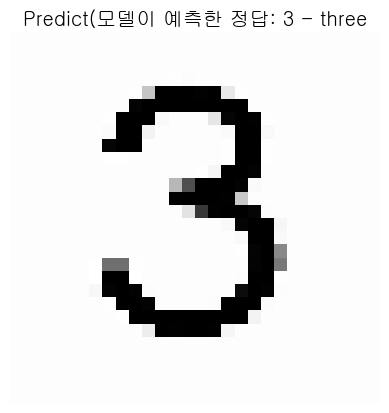

In [100]:
predict_number=loaded_model_0(transformed_image).argmax(dim=1) # loaded_model_0에 transformed 시킨 이미지를 입력함
classes[predict_number] # 3-three라고 잘 인식한다.
plt.figure()
plt.imshow(transformed_image.permute(1,2,0),cmap='gray') # 숫자 3.jpg를 모델이 예측함.
plt.title(f'Predict(모델이 예측한 정답: {classes[predict_number]}')
plt.axis(False)
plt.show()